# Easy

## 5E1

**A:** (2) and (4)

## 5E2

$$ \mu_{i} = \alpha + \beta_{L}L_{i} + \beta_{P}P_{i}$$

## 5E3

$$ \mu_{i} = \alpha + \beta_{F}F_{i} + \beta_{L}L_{i}$$

The important thing here to note is that Funding (F) and size of Lab (L) are correlated with each other. If their correlation is negative then they both affect the result positively. If their relation is positive, they should be on the opposite side of zero. The question actually leaves open which is the case here...

## 5E4

**A:** (1), (3), (4) and (5) are inferentially equivalent. (2) stands out because of the redundant parameter a.

# Medium

## 5M1

In [114]:
from scipy.stats import norm
import pandas as pd
import seaborn as sns
%matplotlib inline

n = 100
x_real = norm(0,1).rvs(100)
x_spurr = norm.rvs(x_real)
y = norm.rvs(x_real)
d = pd.DataFrame({
   "y": y,
    "x_real": x_real,
    "x_spurr": x_spurr
    
})

In [115]:
from numpy import corrcoef

corrcoef([x_real, x_spurr, y])

array([[1.        , 0.74923711, 0.78811377],
       [0.74923711, 1.        , 0.66742721],
       [0.78811377, 0.66742721, 1.        ]])

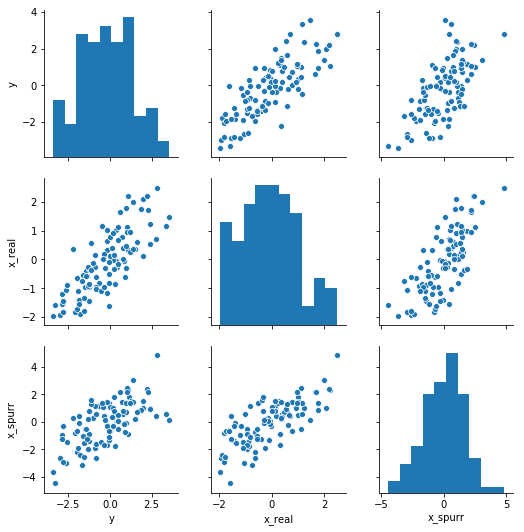

In [116]:
sns.pairplot(d);

In [117]:
import pymc3 as pm

with pm.Model() as m_5m1:
    sigma = pm.HalfNormal('sigma', sd=1)
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_r = pm.Normal('beta_r', mu=0, sd=5)
    beta_s = pm.Normal('beta_s', mu=0, sd=5)
    mu = alpha + beta_r*d.x_real + beta_s*d.x_spurr
    y = pm.Normal('y', mu, sigma, observed=d.y)
    
    trace_5m1 = pm.sample()

pm.summary(trace_5m1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_s, beta_r, alpha, sigma]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2934.50draws/s]
The acceptance probability does not match the target. It is 0.8878323389543832, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.101239,0.093674,0.002212,-0.273387,0.084715,1854.377233,1.000978
beta_r,0.946184,0.139140,0.003723,0.658867,1.215357,1230.007414,1.000966
beta_s,0.171286,0.094663,0.002569,-0.015128,0.358797,1145.436059,1.001042
sigma,0.957709,0.066521,0.001501,0.837781,1.090249,1735.474217,0.999239


In [118]:
# How does it look if we model bivariate  relationships?
# For simplicity with glms

from sklearn.linear_model import LinearRegression

glm_real = LinearRegression().fit(d["x_real"].values.reshape(-1,1), d['y'])
glm_real.intercept_, glm_real.coef_

(-0.09146804930928011, array([1.13323232]))

In [119]:
glm_real = LinearRegression().fit(d["x_spurr"].values.reshape(-1,1), d['y'])
glm_real.intercept_, glm_real.coef_

(-0.15837970330604295, array([0.65608675]))

In [120]:
glm_real = LinearRegression().fit(d.drop("y", axis=1), d['y'])
glm_real.intercept_, glm_real.coef_

(-0.10023962539649364, array([0.94425608, 0.17243096]))

**A:** As we can see the spurious correlation is discovered when using both variables as predictors. X_real is discovered as the better predictor and only very little of the remaining variance is explaning by x_spurr after controling for x_real.

## 5M2

In [212]:
from numpy import sqrt

n = 100
rho = -0.7
x_1 = norm(0,1).rvs(100)
x_2 = norm.rvs(x_1*rho, sqrt(1-rho**2))
mu_y = x_1 + x_2
y = norm.rvs(mu_y)

d = pd.DataFrame({
   "y": y,
    "x_1": x_1,
    "x_2": x_2
    
})

In [213]:
corrcoef([x_1, x_2, y])

array([[ 1.        , -0.73711911,  0.35825047],
       [-0.73711911,  1.        ,  0.1557445 ],
       [ 0.35825047,  0.1557445 ,  1.        ]])

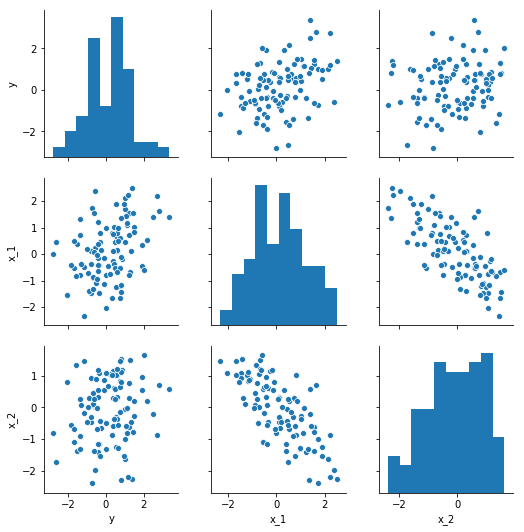

In [214]:
sns.pairplot(d);

In [215]:
with pm.Model() as m_5m2:
    alpha = pm.Normal("alpha", mu=0, sd=1)
    beta_1 = pm.Normal("beta_1", mu=0, sd=1)
    beta_2 = pm.Normal("beta_2", mu=0, sd=1)
    mu = alpha + beta_1 * d.x_1 + beta_2 * d.x_2
    sigma = pm.HalfNormal("sigma", sd=1)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d.y)
    
    trace_5m2 = pm.sample()
    
pm.summary(trace_5m2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_2, beta_1, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3075.62draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.126533,0.081388,0.002022,-0.028891,0.281504,1500.252612,1.000371
beta_1,1.077147,0.113075,0.002686,0.856467,1.301323,1633.736474,0.999199
beta_2,1.050314,0.123527,0.003049,0.822526,1.295280,1676.563015,0.999216
sigma,0.829710,0.059011,0.001340,0.712232,0.942690,1725.416777,0.999227


In [216]:
from sklearn.linear_model import LinearRegression

glm_real = LinearRegression().fit(d["x_1"].values.reshape(-1,1), d['y'])
glm_real.intercept_, glm_real.coef_

(0.12233645080141826, array([0.3839849]))

In [217]:
glm_real = LinearRegression().fit(d["x_2"].values.reshape(-1,1), d['y'])
glm_real.intercept_, glm_real.coef_

(0.1908136186688859, array([0.18339249]))

In [218]:
glm_real = LinearRegression().fit(d.drop("y", axis=1), d['y'])
glm_real.intercept_, glm_real.coef_

(0.12344751825351519, array([1.11032035, 1.08253269]))

**A:** As we can see x_1 and x_2 are negatively correlated. But together they both have a positive influence on y.

## 5M3